# Q1: Control VAE

### LOAD THE DATA:

In [1]:
# LOAD  dSprites (2D shape) DATA at this link:
# https://github.com/google-deepmind/dsprites-dataset
#  the pictures are 64x64 pixels one channel (binary)
# load the libraries:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [17]:
def load_dsprites():
    file_name = "./sh3_sc6_y32_x32_imgs.npz"
    data = np.load(file_name, allow_pickle=True, encoding="latin1")
    imgs = data["imgs"]
    return imgs

imgs = load_dsprites()


imgs.shape: (18432, 64, 64)
imgs.dtype: uint8
imgs.min(): 0
imgs.max(): 1
imgs_sample.shape: (10, 64, 64)


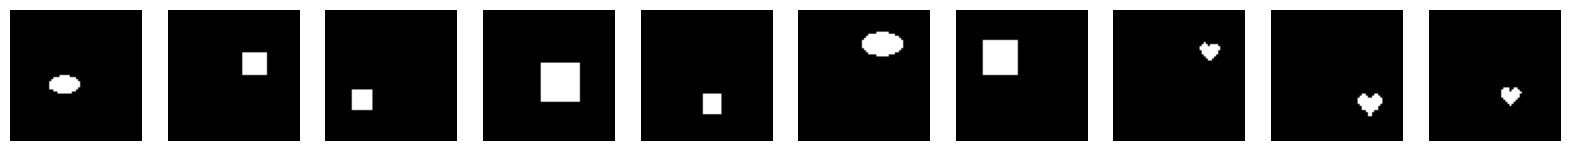

In [3]:
# checl the data:
print("imgs.shape:", imgs.shape)
print("imgs.dtype:", imgs.dtype)
print("imgs.min():", imgs.min())
print("imgs.max():", imgs.max())
# show ten random images:
n = 10
idx = np.random.randint(0, imgs.shape[0], n)
imgs_sample = imgs[idx, :, :]
print("imgs_sample.shape:", imgs_sample.shape)
# plot the images:
fig, axs = plt.subplots(1, n, figsize=(20, 2))
for i in range(n):
    axs[i].imshow(imgs_sample[i, :, :], cmap="gray")
    axs[i].axis("off")
plt.show()


## 1.2 VAE implementation

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# Variational Autoencoder (VAE)
class Encoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1)  # This is the additional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1)

        self.fc_intermediate = nn.Linear(256 * 2 * 2, 256)  # Intermediate fully connected layer
        self.fc_mean = nn.Linear(256, latent_dim)  # Fully connected layer for mean
        self.fc_log_var = nn.Linear(256, latent_dim)  # Fully connected layer for log variance


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))  # Pass through the additional layer
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc_intermediate(x))  # Pass through the intermediate layer
        z_mean = self.fc_mean(x)  # Compute the mean
        z_log_var = self.fc_log_var(x)  # Compute the log variance
        return z_mean, z_log_var



class Decoder(nn.Module):
    def __init__(self, latent_dim=10, output_channels=1):
        super(Decoder, self).__init__()
        # Fully connected layer
        # self.fc = nn.Linear(latent_dim, 256*4*4)
        self.fc = nn.Linear(latent_dim, 256)
        # Transposed convolutional layers
        # self.upconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=0)  # To get a 4x4 spatial size
        self.upconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=1)
        self.conv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        # x = x.view(-1, 256, 4, 4)  # Reshape to (batch_size, 256, 4, 4)
        x = x.view(-1, 256, 1, 1)
        x = F.relu(self.upconv1(x))  # Upconv to 4x4 spatial size with 256 channels
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        
        x = F.relu(self.conv2(x))
        # print(x.shape)

        x = F.relu(self.conv3(x))
        # print(x.shape)

        x = F.relu(self.conv4(x))
        # print(x.shape)

        # Sigmoid activation for the final layer to get the binary image output
        reconstruction = torch.sigmoid(self.conv5(x))
        return reconstruction


class VAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        return self.decoder(z), z_mean, z_log_var


def vae_loss(reconstruction, x, z_mean, z_log_var):
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return (reconstruction_loss + kl_loss) , reconstruction_loss, kl_loss


In [6]:
# Data loader
class DSpritesDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file, allow_pickle=True, encoding='latin1')
        self.imgs = data['imgs']

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        img = img.astype(np.float32)  
        img = np.expand_dims(img, axis=0)  # Add channel dimension (C, H, W)
        return torch.from_numpy(img)

# Training function
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    reconstruction_loss_epoch = 0
    kl_loss_epoch = 0
    # for batch_idx, (data, _) in enumerate(train_loader):
    # for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Train Epoch {epoch}", leave=False)):
    for batch_idx, data in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, z_mean, z_log_var = model(data)
        # print the shapes:
        # print("data.shape:", data.shape)
        # print("reconstruction.shape:", reconstruction.shape)
        # print("z_mean.shape:", z_mean.shape)
        # print("z_log_var.shape:", z_log_var.shape)
        
        loss, reconstruction_loss, kl_loss = vae_loss(reconstruction, data, z_mean, z_log_var)
        
        reconstruction_loss_epoch += reconstruction_loss.item() / len(data)
        kl_loss_epoch += kl_loss.item() / len(data)
        # devide by the batch_size:
        loss = loss / len(data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # if batch_idx % log_interval == 0:
        #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
        #           f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}")
    return train_loss / len(train_loader), reconstruction_loss_epoch / len(train_loader), kl_loss_epoch / len(train_loader)



In [7]:
# Hyperparameters
batch_size = 64
epochs = 20
log_interval = 10  # Interval for displaying training info.

# Assuming the DSprites npz file is in the same directory as this script
file_name = "./sh3_sc6_y32_x32_imgs.npz"

# Create the dataset and dataloader
dsprites_dataset = DSpritesDataset(file_name)
train_loader = DataLoader(dsprites_dataset, batch_size=batch_size, shuffle=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [8]:

# Instantiate the VAE
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, betas=(0.9, 0.99))

losses = []
reconstruction_losses = []
kl_losses = []


100%|██████████| 288/288 [01:29<00:00,  3.22it/s]


====> Epoch: 1 Average loss: 1070.0729


100%|██████████| 288/288 [00:46<00:00,  6.19it/s]


====> Epoch: 2 Average loss: 543.3315


100%|██████████| 288/288 [00:46<00:00,  6.14it/s]


====> Epoch: 3 Average loss: 203.0933


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 4 Average loss: 124.9091


100%|██████████| 288/288 [00:46<00:00,  6.18it/s]


====> Epoch: 5 Average loss: 117.6680


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 6 Average loss: 114.6689


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 7 Average loss: 112.4154


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 8 Average loss: 110.3516


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 9 Average loss: 109.1245


100%|██████████| 288/288 [00:46<00:00,  6.16it/s]


====> Epoch: 10 Average loss: 107.6238


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 11 Average loss: 106.0906


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 12 Average loss: 105.2261


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 13 Average loss: 104.0033


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 14 Average loss: 102.9395


100%|██████████| 288/288 [00:46<00:00,  6.18it/s]


====> Epoch: 15 Average loss: 101.9219


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 16 Average loss: 100.7191


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 17 Average loss: 99.6624


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 18 Average loss: 98.6419


100%|██████████| 288/288 [00:46<00:00,  6.17it/s]


====> Epoch: 19 Average loss: 96.7501


100%|██████████| 288/288 [00:46<00:00,  6.15it/s]

====> Epoch: 20 Average loss: 93.3811


In [ ]:
# Training loop
for epoch in range(1, epochs + 1):
    loss, reconstruction_loss, kl_loss = train(epoch, vae, train_loader, optimizer)
    losses.append(loss)
    reconstruction_losses.append(reconstruction_loss)
    kl_losses.append(kl_loss)


## 1.3 evaluation

In [28]:
print(type(reconstruction_losses))
# print(reconstruction_losses.dtype)
reconstruction_losses[0]
print(kl_losses)

<class 'list'>
[14.559776978187276, 13.87511968281534, 22.952930516666836, 23.707262913386028, 22.777547200520832, 22.229065775871277, 21.7142737309138, 21.09688361485799, 20.630693488650852, 20.098304841253494]


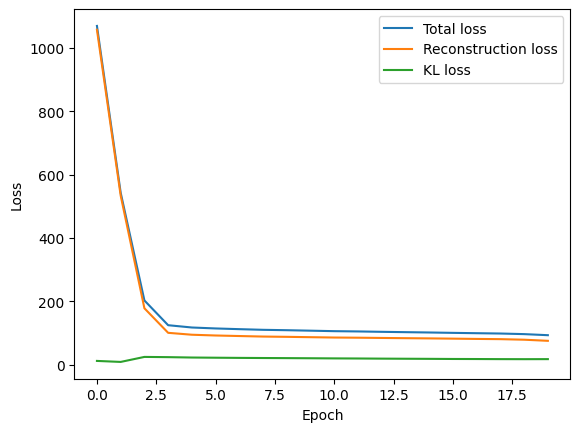

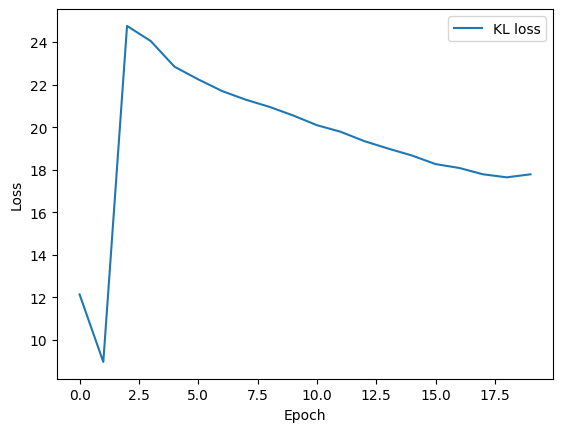

In [9]:
# Plot the training curves
fig, ax = plt.subplots()
ax.plot(losses, label='Total loss')
ax.plot(reconstruction_losses, label='Reconstruction loss')
ax.plot(kl_losses, label='KL loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()
# plot kl seprately:
fig, ax = plt.subplots()
ax.plot(kl_losses, label='KL loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


reconstruction.shape: (50, 1, 64, 64)


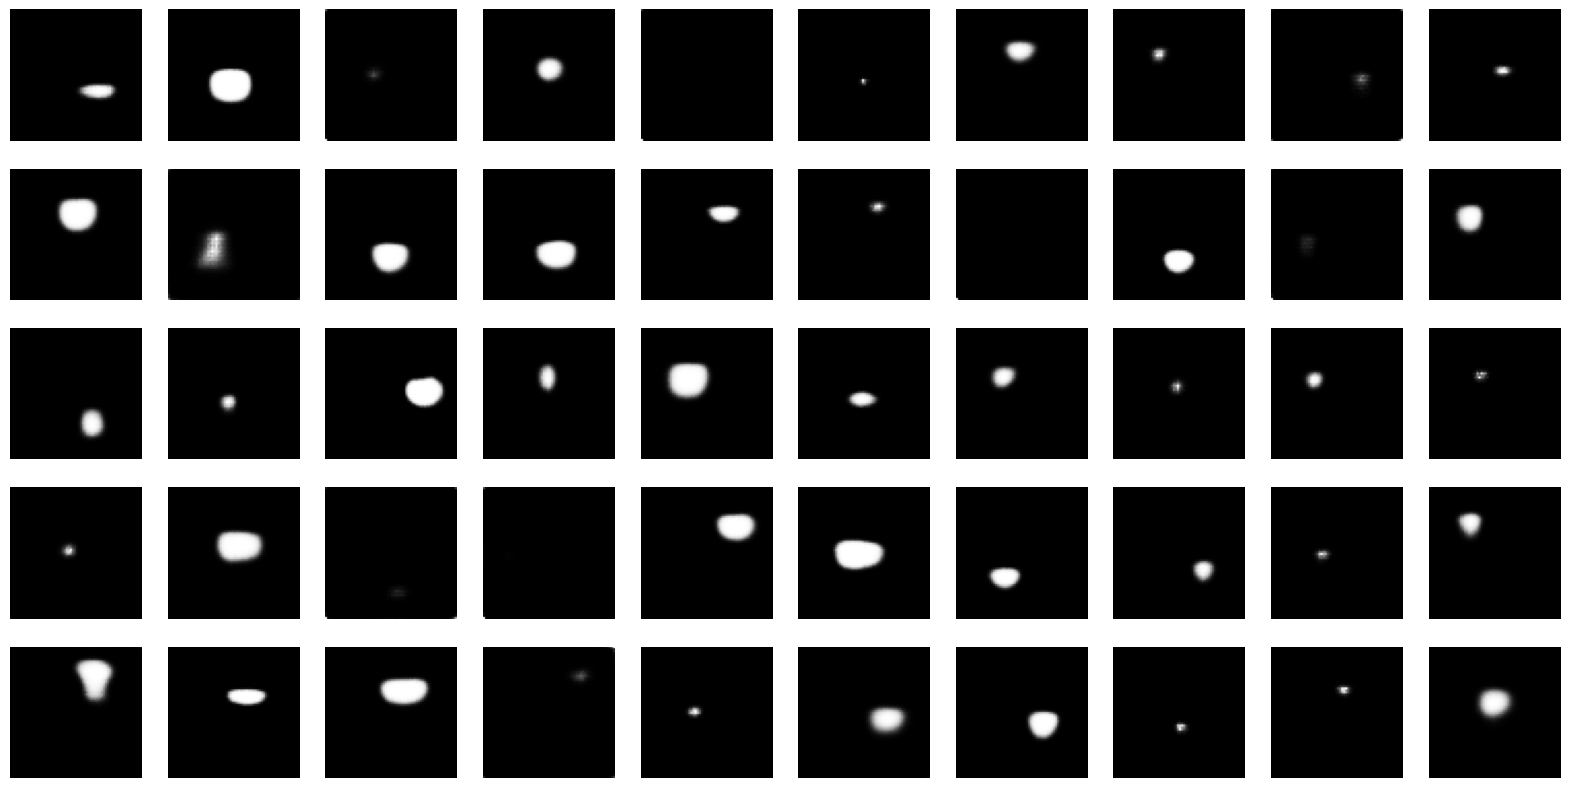

max_value: 0.9999825


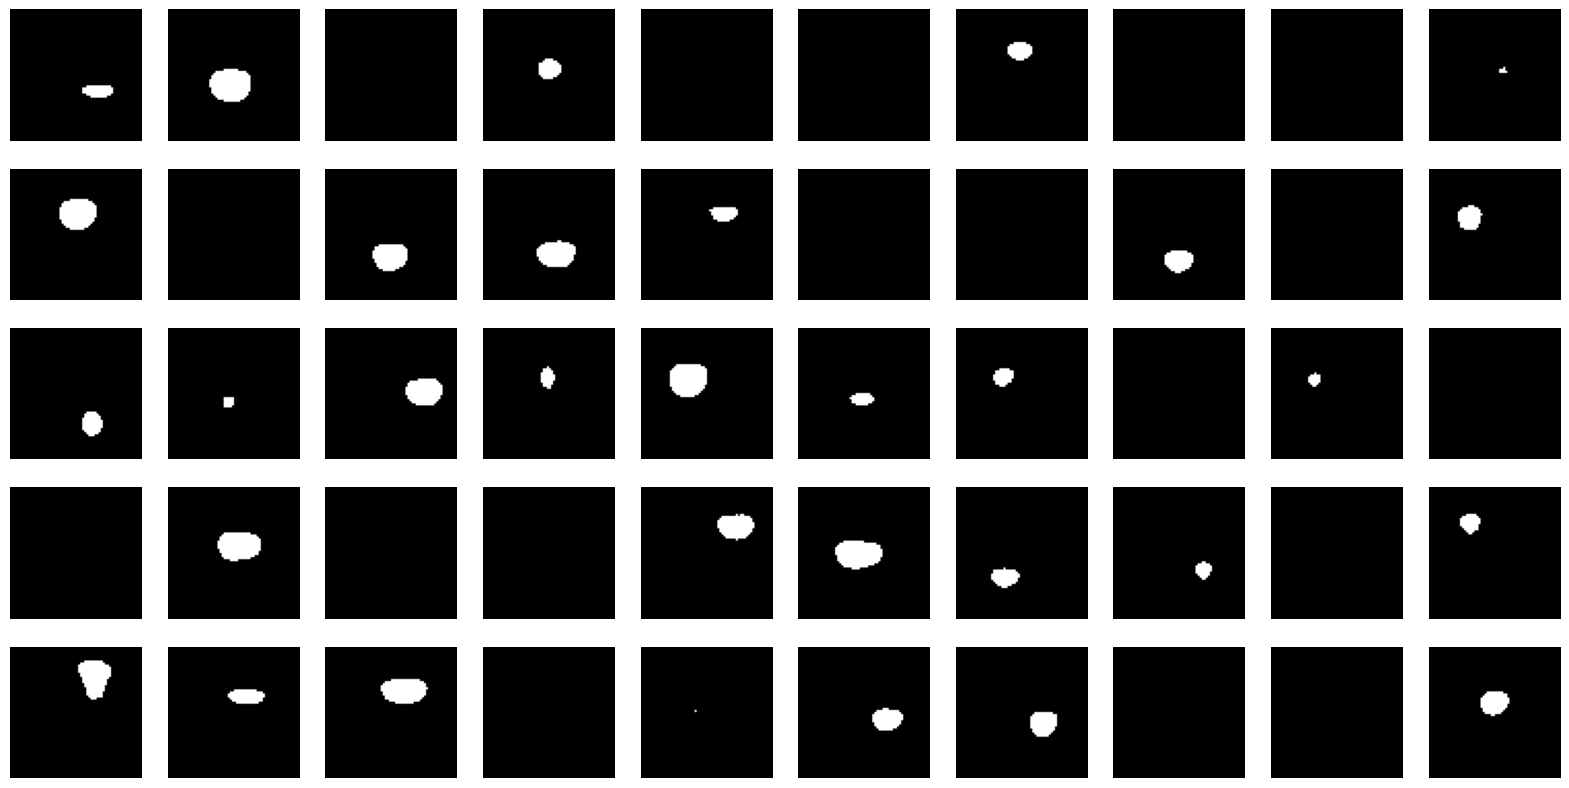

In [10]:
# generate some pictures, in a 5*10 grid:
n = 50
z = torch.randn(n, 10).to(device)
reconstruction = vae.decoder(z).cpu().detach().numpy()
print("reconstruction.shape:", reconstruction.shape)

# print(reconstruction)
# plot the images:
# print(reconstruction[0, 0, :, :])
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        axs[i, j].imshow(reconstruction[i*10+j, 0, :, :], cmap="gray")
        axs[i, j].axis("off")
plt.show()

# apply the threshold:
# get the max value:
max_value = reconstruction.max()
print("max_value:", max_value)
reconstruction = (reconstruction > 0.5).astype(np.uint8)
# plot the images:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        axs[i, j].imshow(reconstruction[i*10+j, 0, :, :], cmap="gray")
        axs[i, j].axis("off")
plt.show()


### 1.3. FID:

In [ ]:
# !pip install pytorch-fid

In [4]:
# calculate the FID score:
# using the https://github.com/mseitzer/pytorch-fid repo:
from pytorch_fid import fid_score
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


In [ ]:

# generate 5000 images and save them:
n = 5000
z = torch.randn(n, 10).to(device)
reconstruction = vae.decoder(z).cpu().detach().numpy()
# binarize the images:
reconstruction = (reconstruction > 0.5).astype(np.uint8)

if not os.path.exists("./reconstruction"):
    os.makedirs("./reconstruction")
# save the images:
for i in range(n):
    plt.imsave(f"./reconstruction/{i}.png", reconstruction[i, 0, :, :], cmap="gray")


In [18]:
imgs = load_dsprites()
# randomly select 5000 of the real images :
dataset_len = imgs.__len__()
idxs = np.random.randint(0, dataset_len, 5000)
print(idxs.shape)
# imgs_sample = dsprites_dataset.imgs[idxs, :, :]
if not os.path.exists("./real_imgs"):
    os.makedirs("./real_imgs")
# save the images:
for i in idxs:
    plt.imsave(f"./real_imgs/{i}.png", imgs[i, :, :], cmap="gray")

(5000,)


In [22]:
# clear gpu memory:
# del imgs
# del reconstruction
# del z
# del reconstruction
# del idxs
# del dsprites_dataset
# del train_loader
# del vae
# del optimizer
torch.cuda.empty_cache()

In [5]:
# calculate the FID score:
fid_value = fid_score.calculate_fid_given_paths(["./real_imgs", "./reconstruction"], batch_size=32, device="cuda", dims=2048)
print("fid_value:", fid_value)


100%|██████████| 157/157 [04:33<00:00,  1.74s/it]


fid_value: 82.26925797704074


In [ ]:
# https://chat.openai.com/c/e7235bbd-eb6b-45af-a27a-f913ab1c5c95
# https://chat.openai.com/c/04ae67ac-aca4-41f3-b2d9-75498c253190


## 1.4 Comtrol VAE implementation

In [ ]:


import torch
from torch import nn
from torch.nn import functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=2)
        self.fc_mu = nn.Linear(in_features=256, out_features=10)
        self.fc_logvar = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=10, out_features=256)
        self.upconv1 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2)
        self.upconv2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)
        self.upconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2)
        self.upconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2)
        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2)

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(-1, 256, 1, 1)
        z = F.relu(self.upconv1(z))
        z = F.relu(self.upconv2(z))
        z = F.relu(self.upconv3(z))
        z = F.relu(self.upconv4(z))
        z = torch.sigmoid(self.upconv5(z))
        return z

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def pi_controller(kl_divergence, target_kl, Kp, Ki, beta_min, beta_max):
    e = target_kl - kl_divergence
    P = Kp * e
    I = Ki * e + beta_min
    beta = P + I
    beta = min(beta, beta_max)
    beta = max(beta, beta_min)
    return beta

# Instantiate the model
vae = VAE()

# Define optimizer
# set the beta to 0.9 and 0.99
beta_min = 0.9
beta_max = 0.99
optimizer = torch.optim.Adam(vae.parameters(), )

# Training loop
for epoch in range(num_epochs):
    for x in data_loader:
        # Forward pass
        recon_x, mu, logvar = vae(x)
        
        # Compute the loss
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        beta = pi_controller(kl_divergence, target_kl, Kp, Ki, beta_min, beta_max)
        loss = loss_function(recon_x, x, mu, logvar, beta)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



### 1.4. evaluation